# Q&A Platform AB Testing Analysis


### Author: Giang (GiGi) Nguyen

### Intro

The data challenge simulates a typical experiment analysis you would be expected to work on at an question-and-answer patform. In this challenge, we will provide several datasets and ask you to analyze the results and provide product recommendations for a particular experiment. 


### Case Study
The platform has just introduced a new UI design to the app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

For the privacy of the data, I will only make the dataset visible in this Jupyter Notebook without posting the actual data on github.

### Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas import DataFrame, Series
import statsmodels.stats.api as sms
import datetime as dt
from scipy import stats
import random
import math
import time
import pytz

from matplotlib.colors import ListedColormap
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set_palette("husl")


### Overview

Table Schema

t1_user_active_min.csv
This table contains active minutes data logged after experiment started.
Each row represents the total number of minutes spent on site for each user on a date.
If a user never visited the site for a given date, there wouldn't be data for that uid on that date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t2_user_variant.csv
This table contains users’ treatment assignment.
Each row represents the assignment information for a unique user.
- uid: user ID
- variant_number: the experiment variant user is in. 0 for control, 1 for treatment
- dt: date when user entered the experiment, should be ‘2019-02-06’ for all users
- signup_date: the date string that user signed up on
  
t3_user_active_min_pre.csv
This table contains active minutes data before the experiment started.
It has a similar format as t1, except the dt range can extend before the experiment start date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t4_user_attributes.csv
This table contains data about some user attributes.
Each row represents attributes of a unique user.
- uid: user ID
- user_type: segment that a user belongs to, measured by activity level of the user. Can be ‘new_user’, ‘non_reader’, ‘reader’ or ‘contributor’
- gender: user gender. Can be ‘male’, ‘female’ or ‘unknown’

### Load Data

In [2]:
t1 = pd.read_csv('t1_user_active_min.csv')
t2 = pd.read_csv('t2_user_variant.csv')
t3 = pd.read_csv('t3_user_active_min_pre.csv')
t4 = pd.read_csv('t4_user_attributes.csv')

### EDA

In [3]:
t1.sort_values(by='dt').head()

,uid,dt,active_mins
459952,20697,2019-02-06,1.0
788773,35713,2019-02-06,66.0
898421,40656,2019-02-06,40.0
991006,45833,2019-02-06,3.0
154521,6914,2019-02-06,2.0


In [4]:
t1.sort_values(by='dt').tail()

,uid,dt,active_mins
815851,36855,2019-07-05,2.0
73229,3297,2019-07-05,28.0
646306,29231,2019-07-05,1.0
218559,9817,2019-07-05,2.0
1024476,47734,2019-07-05,2.0


In [5]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066402 entries, 0 to 1066401
Data columns (total 3 columns):
uid            1066402 non-null int64
dt             1066402 non-null object
active_mins    1066402 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ MB


In [6]:
t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
uid               50000 non-null int64
variant_number    50000 non-null int64
dt                50000 non-null object
signup_date       50000 non-null object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [7]:
t2.groupby('variant_number').count()

,uid,dt,signup_date
variant_number,,,
0,40000,40000,40000
1,10000,10000,10000


In [8]:
t1[['uid']].nunique()

uid    46633
dtype: int64

In [9]:
t1_t2_join = pd.merge(t1, t2[['uid','variant_number']], how='right', left_on='uid', right_on='uid').dropna()

In [10]:
t1_t2_join[['uid']].nunique()

uid    46633
dtype: int64

In [11]:
t1_t2_join.groupby(['variant_number']).nunique()

,uid,dt,active_mins,variant_number
variant_number,,,,
0,37425,150,818,1
1,9208,150,723,1


In [12]:
t1_t2_join.groupby(['variant_number']).count()

,uid,dt,active_mins
variant_number,,,
0,886957,886957,886957
1,179445,179445,179445


In [13]:
t1_t2_join.groupby(['variant_number']).mean()

,uid,active_mins
variant_number,,
0,20010.716644,35.344199
1,45031.472228,40.240408


In [14]:
control = t1_t2_join.loc[t1_t2_join['variant_number']==0]
exp = t1_t2_join.loc[t1_t2_join['variant_number']==1]

## 1) Unit of Analysis

Calculate sum active minutes per user for each sample 
--> Explore and remove outliers

### Control group

In [15]:
control_sum = control[['uid','active_mins']].groupby('uid').sum()

In [16]:
control_sum.head()

,active_mins
uid,
0,43.0
1,15205.0
2,17.0
3,77.0
4,39.0


In [17]:
control_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37425 entries, 0 to 39999
Data columns (total 1 columns):
active_mins    37425 non-null float64
dtypes: float64(1)
memory usage: 584.8 KB


Text(0.5, 1.0, 'original distribution')

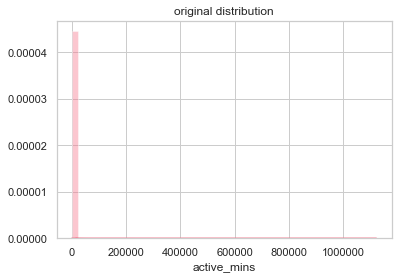

In [18]:
sns.distplot(control_sum.active_mins)
plt.title('original distribution')

### Filter Outliers


In [19]:
stats.iqr(control_sum['active_mins'])

175.0

In [20]:
control_sum['active_mins'].quantile([.25, .75])

0.25     16.0
0.75    191.0
Name: active_mins, dtype: float64

In [21]:
lower_whisker = 16 - 1.5*stats.iqr(control_sum['active_mins'])
upper_whisker = 191 + 1.5*stats.iqr(control_sum['active_mins'])

In [22]:
control_sum_nor = control_sum.loc[control_sum['active_mins']>lower_whisker]
control_sum_nor = control_sum_nor.loc[control_sum_nor['active_mins']<upper_whisker]

In [23]:
control_sum_nor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31870 entries, 0 to 39999
Data columns (total 1 columns):
active_mins    31870 non-null float64
dtypes: float64(1)
memory usage: 498.0 KB


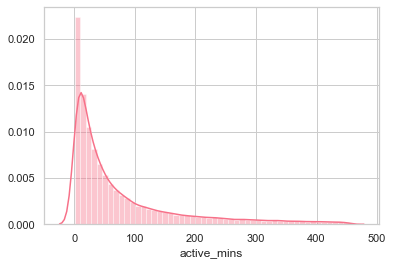

In [24]:
sns.distplot(control_sum_nor.active_mins)

Since we see that this does not follow normal distribution, we are going to apply log to see if we can transform it to normal distribution.

In [25]:
control_sum_nor['log_mins'] = np.log(control_sum_nor['active_mins'])

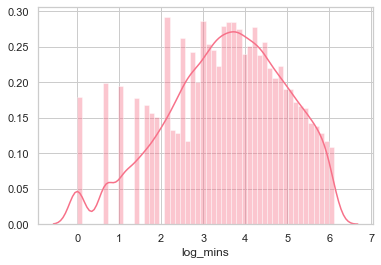

In [26]:
sns.distplot(control_sum_nor.log_mins)

### Experiment group

In [27]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179445 entries, 886957 to 1066401
Data columns (total 4 columns):
uid               179445 non-null int64
dt                179445 non-null object
active_mins       179445 non-null float64
variant_number    179445 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.8+ MB


In [28]:
exp_sum = exp[['uid','active_mins']].groupby('uid').sum()
exp_sum.head()

,active_mins
uid,
40000,25.0
40001,299.0
40002,183.0
40004,56.0
40005,289.0


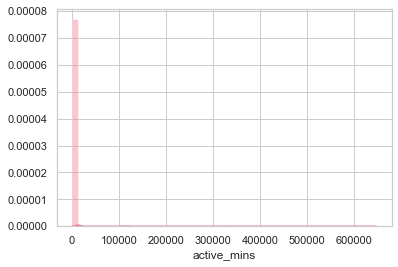

In [29]:
sns.distplot(exp_sum.active_mins)

### Filter Outliers

In [30]:
stats.iqr(exp_sum['active_mins'])

204.0

In [31]:
exp_sum['active_mins'].quantile([.25, .75])

0.25     23.0
0.75    227.0
Name: active_mins, dtype: float64

In [32]:
lower_whisker = 23 - 1.5*stats.iqr(exp_sum['active_mins'])
upper_whisker = 227 + 1.5*stats.iqr(exp_sum['active_mins'])

In [33]:
exp_sum_nor = exp_sum.loc[exp_sum['active_mins']>lower_whisker]
exp_sum_nor = exp_sum_nor.loc[exp_sum_nor['active_mins']<upper_whisker]

In [34]:
exp_sum_nor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7932 entries, 40000 to 49999
Data columns (total 1 columns):
active_mins    7932 non-null float64
dtypes: float64(1)
memory usage: 123.9 KB


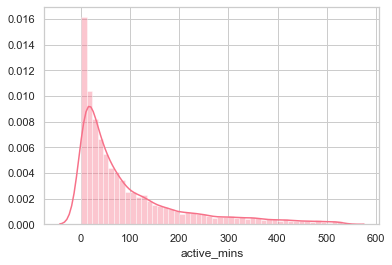

In [35]:
sns.distplot(exp_sum_nor.active_mins)

Since we see that this does not follow normal distribution, we are going to apply log to see if we can transform it to normal distribution.

In [36]:
exp_sum_nor['log_mins'] = np.log(exp_sum_nor['active_mins'])

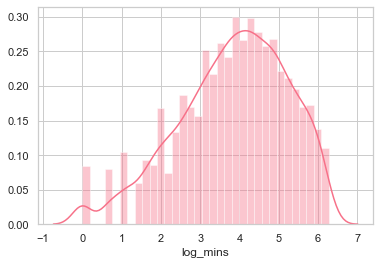

In [37]:
sns.distplot(exp_sum_nor.log_mins)

### Join 2 dataframe

In [38]:
control_sum_nor['variant_number'] = 0
control_sum_nor_sample = control_sum_nor.sample(n=8000)

exp_sum_nor['variant_number'] = 1

sum_join = pd.concat([control_sum_nor,exp_sum_nor])
sum_join_boot = pd.concat([control_sum_nor_sample,exp_sum_nor])

In [39]:
sum_join.groupby('variant_number').count()

,active_mins,log_mins
variant_number,,
0,31870,31870
1,7932,7932


In [40]:
sum_join_boot.groupby('variant_number').count()

,active_mins,log_mins
variant_number,,
0,8000,8000
1,7932,7932


## 2) Perform t-test

Use only tables 1 (t1_user_active_min.csv) and 2 (t2_user_variant.csv) for this question. 

We suspect that there might be inaccuracies in the minutes spent on site data in some rows. Think about the definition of the metric and check if there are any outliers in the data. In this context, outliers mean numbers that are obviously different due to logging errors. If so, remove them; if not, use all the data. 

Using t-test under your assumption about variance, find an appropriate 95% confidence interval of the overall average treatment effect (using the unit of analysis you identified in the previous section).

Enter the confidence interval below. Please round your answer to second place after the decimal.

Based on your findings, what is your recommended course of action regarding the new UI design? You can justify your choice in the next box. Justify your answer.

**We are going to apply t-test on our log-transform data**

In [43]:
def t_test_log(control, exp, variables):

    """Using parametric bootstrap method to draw the sample with replacement
    and calculate the difference in mean between 2 samples until we reach normal distribution
    control: control group
    exp: experiment group
    variables: subject of measurement"""
    
    print ("Control group:")
    print ("Mean of active mins = ", math.exp(control_sum_nor[variables].mean()))
    print ("Standard deviation of active mins = ", math.exp(control_sum_nor[variables].std()))
    
    print ("Experimental group:")
    print ("Mean of active mins = ", math.exp(exp_sum_nor[variables].mean()))
    print ("Standard deviation of active mins = ", math.exp(exp_sum_nor[variables].std()))
    
    # Supporting calculation for checking evaluation metrics
    mean_dif = (exp[variables].mean() - control[variables].mean())
    sd = math.sqrt((control[variables].std()**2)/len(control)\
                   +(exp[variables].std()**2)/len(exp))
    
    t_stats = mean_dif/sd
    
    print ("Mean difference = ", math.exp(mean_dif))
    print ("T-test statistics = ", t_stats)
    
    margin_of_error = sd * stats.t.ppf((1 + 0.95) / 2., len(exp_sum_nor)-1)
    
    #Degrees of freedom
    degree_of_freedom = (len(control_sum_nor) + len(exp_sum_nor)) - 2

    #p-value after comparison with the t 
    p_value = 1 - stats.t.cdf(t_stats,df=degree_of_freedom)

    print("P-value is: ", p_value)
    
    (LB_pool, UB_pool) = (math.exp(mean_dif - margin_of_error), math.exp(mean_dif + margin_of_error))
    print ("Confidential interval CI = ", (LB_pool, UB_pool))

In [44]:
t_test_log(control_sum_nor,exp_sum_nor, 'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.3445877065723622
T-test statistics =  16.89727404928203
P-value is:  0.0
Confidential interval CI =  (1.299186297835253, 1.391575714489857)


### Bootstrap test

Since we observed the distribution of the sum active minutes per user for each sample are not approximately normal, we are going to try the bootstrap approach as a sanity check for our hypothesis because bootstrap does not have any assumption about the distribution.

In [45]:
def bootstrap_t_test(table, variable, classes, repetitions):

    """Using parametric bootstrap method to draw the sample with replacement
    and calculate the difference in mean between 2 samples until we reach normal distribution
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations"""

    t = table[[variable, classes]]
    t = t.reset_index()

    # Find the observed test statistic
    means_table = t.groupby([classes]).mean()
    obs_stat = abs(means_table.iloc[1,1] - means_table.iloc[0,1])

    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = []
    random.seed(1)

    for i in np.arange(repetitions):
        #sample with replacement
        bootstrap_var = np.random.choice(t['uid'],10000)
        boot = t[t['uid'].isin(bootstrap_var)]
        m_tbl = boot.groupby([classes]).mean()
        mean_diff = abs(m_tbl.iloc[1,1] - m_tbl.iloc[0,1])
        stats = np.append(stats, mean_diff)

    # Find the empirical P-value:
    emp_p = (stats > obs_stat).sum()/repetitions
    
    
    #confidence interval
    left = np.quantile(stats,0.025)
    right = np.quantile(stats,0.975)

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    sns.distplot(stats, color='red')
    plt.title('Empirical Distribution Under the Null')
    plt.plot([left, right], [0, 0], color='blue', lw=8)
    plt.axvline(obs_stat, color="k", linestyle="--")
    print('Observed statistic:', obs_stat)
    print('Empirical P-value:', emp_p)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Observed statistic: 21.64826714573877
Empirical P-value: 0.5014
Approximate 95% CI for the difference between means:
18.21339519520357 to 25.05216102423972


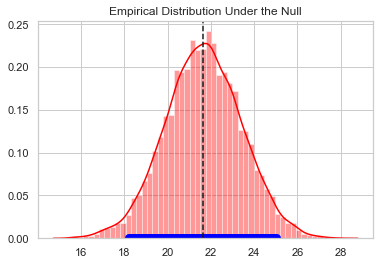

In [46]:
bootstrap_t_test(sum_join_boot, 'active_mins', 'variant_number', 10000)

## 3) Pre period test

You decide to dive deeper into the data, so you gather a table of active minutes by user from before the experiment began. You should now use table 3 (t3_user_active_min_pre.csv) along with tables 1 and 2 for this question.

Using the statistical method of your choice and the pre-experiment data, update your 95% confidence interval of the overall average treatment effect.

Please enter your confidence interval below, after rounding your answer to second place after the decimal.

How does the pre-experiment data change your conclusion about the treatment effect of the experiment? What method do you use to compute your updated treatment effect? 

In [47]:
t3.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [48]:
t3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190093 entries, 0 to 1190092
Data columns (total 3 columns):
uid            1190093 non-null int64
dt             1190093 non-null object
active_mins    1190093 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.2+ MB


In [49]:
pre_sum = t3[['uid','active_mins']].groupby('uid').sum()
pre_sum.head()

,active_mins
uid,
0,70.0
1,19158.0
2,37.0
3,108.0
4,66.0


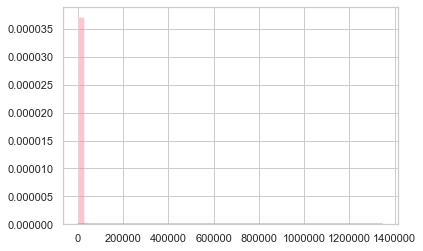

In [50]:
sns.distplot(pre_sum[['active_mins']])

### Filter Outliers

In [51]:
stats.iqr(pre_sum['active_mins'])

163.0

In [52]:
pre_sum['active_mins'].quantile([.25, .75])

0.25     17.0
0.75    180.0
Name: active_mins, dtype: float64

In [53]:
lower_whisker = 17 - 1.5*stats.iqr(pre_sum['active_mins'])
upper_whisker = 180 + 1.5*stats.iqr(pre_sum['active_mins'])

In [54]:
pre_sum_nor = pre_sum.loc[pre_sum['active_mins']>lower_whisker]
pre_sum_nor = pre_sum_nor.loc[pre_sum_nor['active_mins']<upper_whisker]

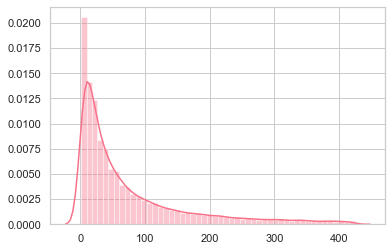

In [55]:
sns.distplot(pre_sum_nor[['active_mins']])

In [56]:
pre_sum_nor['log_mins'] = np.log(pre_sum_nor['active_mins'])

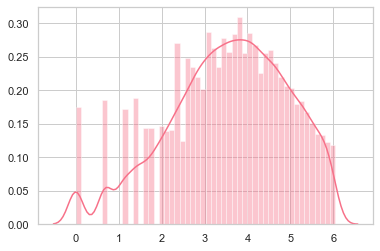

In [57]:
sns.distplot(pre_sum_nor[['log_mins']])

==> Approximately normal

In [58]:
pre_sum_nor_index = pre_sum_nor.reset_index()
first_half = pre_sum_nor_index.sample(frac=0.5)

In [59]:
first_half_filter = np.array(first_half.uid)
second_half = pre_sum_nor_index[~pre_sum_nor_index.uid.isin(first_half_filter)]
second_half.head()

,uid,active_mins,log_mins
4,5,21.0,3.044522
5,6,12.0,2.484907
6,7,34.0,3.526361
7,8,17.0,2.833213
8,9,52.0,3.951244


In [60]:
first_half.head()

,uid,active_mins,log_mins
4895,5853,34.0,3.526361
18301,21776,9.0,2.197225
10361,12360,158.0,5.062595
38014,44846,45.0,3.806662
8313,9922,17.0,2.833213


### Perform t-test

In [61]:
t_test_log(first_half,second_half,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.9968584270366079
T-test statistics =  -0.23511695941986807
P-value is:  0.5929404172458075
Confidential interval CI =  (0.9710471201147197, 1.0233558217406598)


## 4) Sanity Check

In real life, experiment results can be nuanced. We provide you now additionally table 4 (t4_user_attributes.csv), which might help you analyze the results better. You should think about the context of the experiment and hypothesize why the analysis above could be insufficient. Explore the data and share with us your insights!

1. Given the new tables, were there any issues in treatment assignment? Was the treatment effect different for different covariates? 

2. Based on the new findings, what is your conclusion and what product recommendations would you make to the team?

Summarize your findings in a brief write-up with up to 200 words, and include one or two plots that best represent your results. Submit a single PDF file, please.

In [62]:
t4.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [63]:
cat_join = pd.merge(sum_join,t4, how='left', left_on='uid', right_on='uid')
cat_join.head()

,uid,active_mins,log_mins,variant_number,gender,user_type
0,0,43.0,3.761200,0,male,non_reader
1,2,17.0,2.833213,0,male,non_reader
2,3,77.0,4.343805,0,male,non_reader
3,4,39.0,3.663562,0,male,non_reader
4,5,174.0,5.159055,0,female,non_reader


In [64]:
#summary statistics
cat_join.groupby(['variant_number','gender','user_type']).sum()

uid  active_mins      log_mins
variant_number gender  user_type                                        
0              female  contributor    1459793      14936.0    355.104449
                       new_user      15042594      14558.0   1569.889975
                       non_reader   154208489     456263.0  25682.897680
                       reader        17448861     171373.0   4361.596605
               male    contributor    2212073      22007.0    532.459440
                       new_user      21676645      22711.0   2385.368108
                       non_reader   290478952    1066761.0  52643.616188
                       reader        32414949     315106.0   7898.288982
               unknown contributor     481658       4212.0    136.823953
                       new_user       9613097       9877.0    981.192715
                       non_reader    84412175     262568.0  14349.387865
                       reader         7496150      69728.0   1780.914407
1              female  contributor     239063        727.0     23.025205
                       new_user      12278496       9928.0    715.573260
                       non_reader    84503753     152674.0   6904.175957
                       reader         6801420      36734.0    779.051775
               male    contributor     783107       2800.0     80.160274
                       new_user      16707804      13438.0    998.425339
                       non_reader   165655856     380504.0  14742.996582
                       reader        11575258      56549.0   1279.317969
               unknown contributor     462199       1437.0     45.702802
                       new_user       7003623       5391.0    408.463483
                       non_reader    47350829      95766.0   4022.627966
                       reader         3578854      17438.0    392.918424

We can break it down into sub-category and do t-test to examine if there is a Simpson Paradox

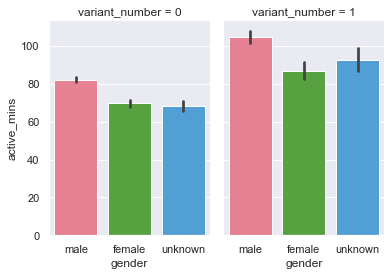

In [65]:
sns.set(rc={'figure.figsize':(15, 7)})

sns.catplot(x="gender", y="active_mins",
                col="variant_number",
                data=cat_join, kind="bar",
                height=4, aspect=.7, palette='husl')

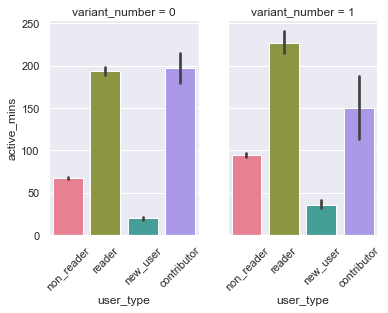

In [66]:
chart1 = sns.catplot(x="user_type", y="active_mins",
                col="variant_number",
                data=cat_join, kind="bar",
                height=4, aspect=.7, palette='husl')
chart1.set_xticklabels(rotation=45)


## Segment users

In [67]:
cat_join['log_mins'] = np.log(cat_join['active_mins'])

In [68]:
control_cat = cat_join[cat_join['variant_number']==0]
exp_cat = cat_join[cat_join['variant_number']==1]

Segment by gender

In [69]:
#control
control_female = control_cat[control_cat['gender']=='female']
control_male = control_cat[control_cat['gender']=='male']
control_unknown = control_cat[control_cat['gender']=='unknown']

#exp
exp_female = exp_cat[exp_cat['gender']=='female']
exp_male = exp_cat[exp_cat['gender']=='male']
exp_unknown = exp_cat[exp_cat['gender']=='unknown']

Segment by user_type

In [70]:
#control
control_nonreader = control_cat[control_cat['user_type']=='non_reader']
control_reader = control_cat[control_cat['user_type']=='reader']
control_contributor = control_cat[control_cat['user_type']=='contributor']
control_newuser = control_cat[control_cat['user_type']=='new_user']

#exp
exp_nonreader = exp_cat[exp_cat['user_type']=='non_reader']
exp_reader = exp_cat[exp_cat['user_type']=='reader']
exp_contributor = exp_cat[exp_cat['user_type']=='contributor']
exp_newuser = exp_cat[exp_cat['user_type']=='new_user']

### Conduct t-test

In [71]:
#gender
t_test_log(control_female,exp_female,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.2959077048455387
T-test statistics =  7.8057632570989375
P-value is:  2.9976021664879227e-15
Confidential interval CI =  (1.2142365990956077, 1.3830721135640878)


In [72]:
t_test_log(control_male,exp_male,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.3454916449866237
T-test statistics =  12.811686034488702
P-value is:  0.0
Confidential interval CI =  (1.285764572527725, 1.407993193629368)


In [73]:
t_test_log(control_unknown,exp_unknown,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.4306673152331675
T-test statistics =  8.170031112885916
P-value is:  2.220446049250313e-16
Confidential interval CI =  (1.3128640033494552, 1.5590411205231773)


In [74]:
t_test_log(control_nonreader,exp_nonreader,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.4545037951912694
T-test statistics =  20.761080500961146
P-value is:  0.0
Confidential interval CI =  (1.4039489188303091, 1.5068791049665742)


In [75]:
t_test_log(control_reader,exp_reader,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.1614734437175838
T-test statistics =  2.764910147570749
P-value is:  0.002848234291462859
Confidential interval CI =  (1.0445255532932516, 1.2915151345104954)


In [76]:
t_test_log(control_contributor,exp_contributor,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.6773202037118512
T-test statistics =  -1.5821811102465961
P-value is:  0.9431919113544908
Confidential interval CI =  (0.4179787189932277, 1.0975742005747826)


**The t-test for "contributor" user type does not show to be statistically significant since the p-value is larger than our signficance level alpha of 0.05**

In [77]:
t_test_log(control_newuser,exp_newuser,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.7584964926201134
T-test statistics =  10.21657333566919
P-value is:  0.0
Confidential interval CI =  (1.577996314063395, 1.9596433065134582)


### Test the pre-period by segments

In [78]:
first_half['variant_number'] = 0 
second_half['variant_number'] = 1

first_join = pd.merge(first_half,t4, how='left', left_on='uid', right_on='uid')
second_join = pd.merge(second_half,t4, how='left', left_on='uid', right_on='uid')

cat_join_pre = pd.concat([first_join,second_join])

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
cat_join_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42578 entries, 0 to 21288
Data columns (total 6 columns):
uid               42578 non-null int64
active_mins       42578 non-null float64
log_mins          42578 non-null float64
variant_number    42578 non-null int64
gender            42578 non-null object
user_type         42578 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [80]:
#summary statistics
cat_join_pre.groupby(['variant_number','gender','user_type']).sum()

uid  active_mins      log_mins
variant_number gender  user_type                                        
0              female  contributor     583831       4747.0    134.983666
                       new_user      20172474       4344.0    980.653539
                       non_reader   128561506     313531.0  18067.499964
                       reader        11208374      93598.0   2395.387314
               male    contributor    1299341      13127.0    289.344057
                       new_user      28953486       6480.0   1454.349537
                       non_reader   237617673     744543.0  36246.747335
                       reader        20251700     169078.0   4224.329155
               unknown contributor     450372       3099.0     83.961667
                       new_user      12236048       2996.0    623.027579
                       non_reader    70802646     187190.0  10215.599313
                       reader         5544999      40032.0   1026.990798
1              female  contributor     543948       5073.0    136.866722
                       new_user      19484349       3962.0    944.025437
                       non_reader   125712925     312380.0  17817.883868
                       reader        11854079      98355.0   2461.829678
               male    contributor    1302462      10795.0    259.472139
                       new_user      29017518       6994.0   1477.944766
                       non_reader   239750552     742222.0  36188.281393
                       reader        22380929     189608.0   4650.549169
               unknown contributor     465509       3847.0     86.007079
                       new_user      12500033       2749.0    615.236159
                       non_reader    68288997     183518.0   9967.329615
                       reader         4978476      42089.0   1070.461674

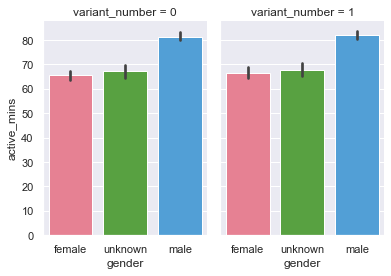

In [81]:
sns.set(rc={'figure.figsize':(15, 7)})

sns.catplot(x="gender", y="active_mins",
                col="variant_number",
                data=cat_join_pre, kind="bar",
                height=4, aspect=.7, palette='husl')

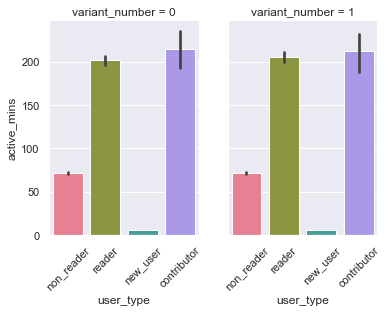

In [82]:
chart2 = sns.catplot(x="user_type", y="active_mins",
                col="variant_number",
                data=cat_join_pre, kind="bar",
                height=4, aspect=.7, palette='husl')

chart2.set_xticklabels(rotation=45)


In [83]:
control_cat_pre = cat_join_pre[cat_join_pre['variant_number']==0]
exp_cat_pre = cat_join_pre[cat_join_pre['variant_number']==1]

In [84]:
#control
control_female_pre = control_cat_pre[control_cat_pre['gender']=='female']
control_male_pre = control_cat_pre[control_cat_pre['gender']=='male']
control_unknown_pre = control_cat_pre[control_cat_pre['gender']=='unknown']

#exp
exp_female_pre = exp_cat_pre[exp_cat_pre['gender']=='female']
exp_male_pre = exp_cat_pre[exp_cat_pre['gender']=='male']
exp_unknown_pre = exp_cat_pre[exp_cat_pre['gender']=='unknown']

In [85]:
#control
control_nonreader_pre = control_cat_pre[control_cat_pre['user_type']=='non_reader']
control_reader_pre = control_cat_pre[control_cat_pre['user_type']=='reader']
control_contributor_pre = control_cat_pre[control_cat_pre['user_type']=='contributor']
control_newuser_pre = control_cat_pre[control_cat_pre['user_type']=='new_user']

#exp
exp_nonreader_pre = exp_cat_pre[exp_cat_pre['user_type']=='non_reader']
exp_reader_pre = exp_cat_pre[exp_cat_pre['user_type']=='reader']
exp_contributor_pre = exp_cat_pre[exp_cat_pre['user_type']=='contributor']
exp_newuser_pre = exp_cat_pre[exp_cat_pre['user_type']=='new_user']

In [86]:
t_test_log(control_female_pre,exp_female_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.99882025330762
T-test statistics =  -0.04799205263402161
P-value is:  0.5191385914031404
Confidential interval CI =  (0.9518038304390334, 1.0481591547675548)


In [87]:
t_test_log(control_male_pre,exp_male_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.9975060426463608
T-test statistics =  -0.1388137329665733
P-value is:  0.5552009779839201
Confidential interval CI =  (0.9629444326692358, 1.0333081238736281)


In [88]:
t_test_log(control_unknown_pre,exp_unknown_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.9829196516328075
T-test statistics =  -0.5155806124245672
P-value is:  0.6969248910746693
Confidential interval CI =  (0.9206003812550644, 1.0494575727296818)


In [89]:
t_test_log(control_nonreader_pre,exp_nonreader_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.986819062203776
T-test statistics =  -1.106448241472041
P-value is:  0.8657303787587862
Confidential interval CI =  (0.9638918865535544, 1.010291584682443)


In [90]:
t_test_log(control_reader_pre,exp_reader_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  1.0075673479761365
T-test statistics =  0.27550713261889026
P-value is:  0.3914640385089929
Confidential interval CI =  (0.9549455629998789, 1.0630888293972771)


In [91]:
t_test_log(control_contributor_pre,exp_contributor_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.9998890525655738
T-test statistics =  -0.0011776103906029076
P-value is:  0.5004697955150792
Confidential interval CI =  (0.8312659385893789, 1.2027175312115634)


In [92]:
t_test_log(control_newuser_pre,exp_newuser_pre,'log_mins')

Control group:
Mean of active mins =  34.313410433706274
Standard deviation of active mins =  4.102090369410104
Experimental group:
Mean of active mins =  46.13738983973328
Standard deviation of active mins =  4.025751083721038
Mean difference =  0.9966768707555497
T-test statistics =  -0.12493724871328762
P-value is:  0.5497130699119003
Confidential interval CI =  (0.9459596858887148, 1.0501132337006767)


### Plotting the time series data

In [93]:
new_join_test = pd.merge(t1_t2_join,t4, how='left', left_on='uid', right_on='uid')
new_join_notest = pd.merge(t3,t4, how='left', left_on='uid', right_on='uid')

new_join = pd.concat([new_join_test,new_join_notest])

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [94]:
new_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256495 entries, 0 to 1190092
Data columns (total 6 columns):
active_mins       float64
dt                object
gender            object
uid               int64
user_type         object
variant_number    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 120.5+ MB


In [95]:
new_sum = new_join[['dt','gender','user_type','active_mins']].groupby(['dt','gender','user_type']).sum().reset_index()
new_sum.head()

,dt,gender,user_type,active_mins
0,2018-08-10,female,contributor,3992.0
1,2018-08-10,female,non_reader,5917.0
2,2018-08-10,female,reader,14055.0
3,2018-08-10,male,contributor,17868.0
4,2018-08-10,male,non_reader,12771.0


In [96]:
new_sum.dt = pd.to_datetime(new_sum.dt)
new_sum = new_sum.set_index('dt')

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


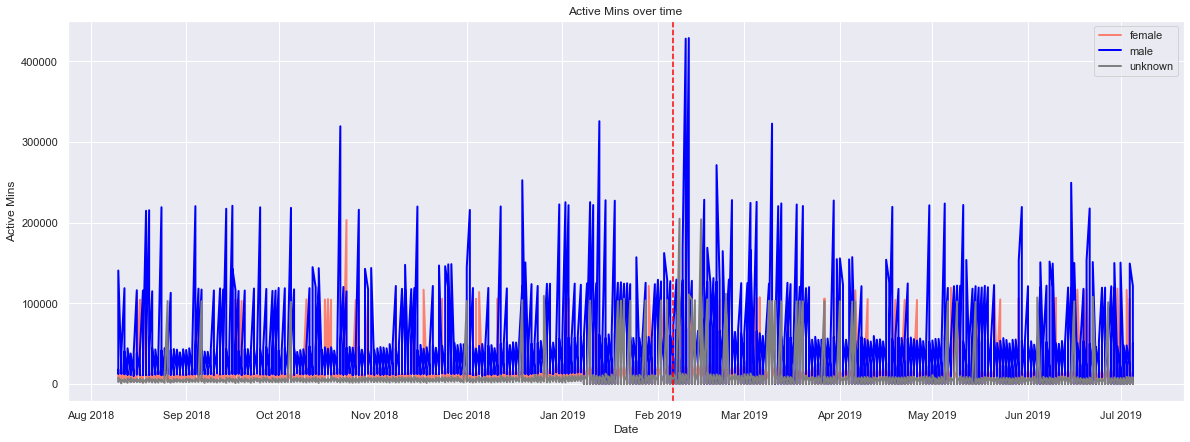

In [97]:
#make a line plot to see the trend of DAU over time
sns.set(rc={'figure.figsize':(20, 7)})

fig, ax = plt.subplots()


ax.plot(new_sum.loc[new_sum['gender']=='female']['active_mins'],linewidth=2, label ='female',color= "salmon")
ax.plot(new_sum.loc[new_sum['gender']=='male']['active_mins'],linewidth=2, label ='male',color= "blue")
ax.plot(new_sum.loc[new_sum['gender']=='unknown']['active_mins'],linewidth=2, label ='unknown',color= "gray")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Active Mins')
ax.set_title('Active Mins over time')
plt.axvline(pd.to_datetime('2019-02-06'), color="red", linestyle="--")


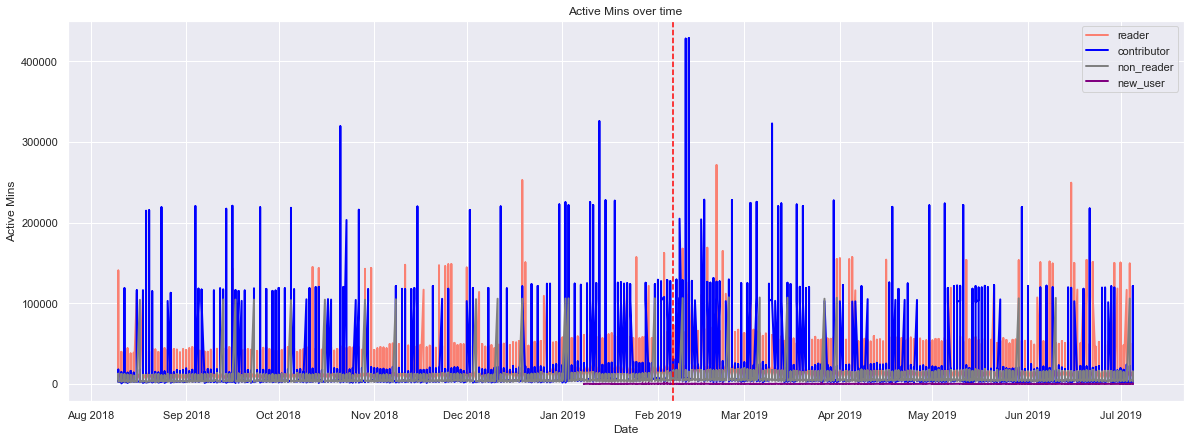

In [98]:
#make a line plot to see the trend of DAU over time
sns.set(rc={'figure.figsize':(20, 7)})

fig, ax = plt.subplots()


ax.plot(new_sum.loc[new_sum['user_type']=='reader']['active_mins'],linewidth=2, label ='reader',color= "salmon")
ax.plot(new_sum.loc[new_sum['user_type']=='contributor']['active_mins'],linewidth=2, label ='contributor',color= "blue")
ax.plot(new_sum.loc[new_sum['user_type']=='non_reader']['active_mins'],linewidth=2, label ='non_reader',color= "gray")
ax.plot(new_sum.loc[new_sum['user_type']=='new_user']['active_mins'],linewidth=2, label ='new_user',color= "purple")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Active Mins')
ax.set_title('Active Mins over time')
plt.axvline(pd.to_datetime('2019-02-06'), color="red", linestyle="--")


## Deep Dive Analysis

Given the user attributes table, I was able to monitor the user engagement analysis on the new UI
change by breaking down the general approach into different segments. Overall, user engagement
metric (total active minutes spend on app) increased approximately 1.3 times for every covariates
within genders and user types, except for “contributor” user sample. Even though “contributor”
user’s engagement in treatment group was less than control one by 20%, the t-test concluded that this
difference only happened by chance without any statistically significant assumption. This could be
the reason why we observed insignificant impact in the bootstrap test.
According

According to the visualization dashboard of total active minutes of users across different segments,
we can see that user engagement for males had the largest difference between treatment and control
groups (about 1.5 times) compared to female and unknown. This is very interesting since the new UI
might get adopted by men than other genders.
Regarding user types, “non_reader” and “new_user” yielded the highest difference in total active
minutes between the 2 samples (approximately 30%). This implies that the new UI not only impact on user
engagement but also user acquisition since these populations are not current or regular users.

According to our findings, here are the product recommendations that I came up with:
- Since the new UI had great impact on new users and non-readers, we can add a
screen/pop-up message to the UI to prompt these users to answer or ask more questions
related to their topics of interest . This can increase the conversion to become
contributors/readers for these users, which eventually benefit growth and retention.
- Explore and analyze the user interactions/activities stream with the new UI and compare the
differences between males and unknown genders versus females. The goal is to customize
UI for each gender group and optimize their engagement rate.